In [2]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from math import log
from IPython.display import Markdown, display
def printmd(string,color = None):
    colorstr= "<span style = 'color:{}'>{}</span>".format(color,string)
    display(Markdown(colorstr))

In [3]:
# helps to reduce amount of memory required for pandas dataframe 
# by downcasting some types 
# but mainly because we replace strings by categorical variables and they are stored better
def memory_optimization(data, cat_cols):
    converted_cat = [0]*len(cat_cols)
    
    #float64 -> float32
    data_float = data.select_dtypes(include=['float'])
    converted_float = data_float.apply(pd.to_numeric, downcast='float')
    data[converted_float.columns] = converted_float
    
    #int64 -> int8 only (0,1) values
    data_int = data.select_dtypes(include=['int64'])
    converted_int = data_int.apply(pd.to_numeric, downcast='integer')
    data[converted_int.columns] = converted_int
    
    #array of strings -> categorical
    for _ in range(len(cat_cols)):
        converted_cat[_] = data[cat_cols[_]].astype('category')
        data[cat_cols[_]] = converted_cat[_]

Data is supposed to be in csv files. The main idea is to load several slices of data.
For example you have age and sex as your attributes and you want to check if the distribution changed or not. 
Last check was, for example two months ago, so you know the distribution on 01.01., but now is 01.03, and you need to understand whether it has changed or not.  
You loading all the data for the 01.01. and for the 01.03, and putting target 0 for the first slice and 1 for the second. You can work with several slices, if you need. If there is some movement in you data, you can investigate the pattern and understand if something goes wrong.


In [7]:
# Information value calculation 
def IV(data, n_good, n_bad, quant, one, zero):
    IV = 0
    try:
        distr_good = len(data[data.target_date == one])/n_good
        distr_bad = len(data[data.target_date == zero])/n_bad
        IV = (distr_good - distr_bad)*log(distr_good/distr_bad)
        print("quant = ", quant, "IV = ", IV)
        
    except:
        #printmd("Не удалось посчитать IV:\n")
        #print("quant = ", quant, "number of '1' = ", len(data[data.target_date == one]), "number of '0' = ", len(data[data.target_date == zero]))
        if (len(data[data.target_date == one]) != 0 or len(data[data.target_date == zero]) != 0):
            printmd("**problem**",color="red")
            print("quant = ", quant, "number of '1' = ", len(data[data.target_date == one]), "number of '0' = ", len(data[data.target_date == zero]))
    return IV

# Working only without NA values 
def psi_calc(data, label, quant,n_good,n_bad,one,zero):
    levels = data[label].quantile(quant)
    print(levels)
    PSI = 0
    targs = data[(data[label] <= levels[quant[0]])]
    PSI = IV(targs,n_good,n_bad,quant[0],one, zero)
    for _ in range(1, len(levels)):
        targs = data[(data[label] <= levels[quant[_]]) & (data[label] > levels[quant[_ - 1]]) ]
        PSI += IV(targs,n_good,n_bad,quant[_],one, zero)
    return PSI
# for categorical variables 
def psi_calc_cat(data, label,n_good,n_bad,one, zero):
    #this is the levels of cat variables 
    levels = data[label].cat.categories
    print(levels)
    PSI = 0
    targs = data[(data[label] == levels[0])]
    PSI = IV(targs,n_good,n_bad,levels[0],one, zero)
    for _ in range(len(levels)):
        targs = data[data[label] == levels[_]][["target_date"]]
        PSI += IV(targs,n_good,n_bad,levels[_],one, zero)
    return PSI

In [8]:
def calc_all(dataset,cat_var,one, zero):
    # последнее значение variables - target_art
    # variables = ["","","target_art"]
    # переменные без категориальных 
    PSI_arr = {}
    variables = [x for x in dataset.columns.values if x not in cat_var]
    n_good = len(dataset[dataset.target_date == one])
    n_bad = len(dataset[dataset.target_date == zero])
    # квантили
    quant = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
    #quant = [.2,.4,.6,.8,1]S
    # для континуальных значений 
    for _ in range(len(variables) - 2):
        print("__________________________________________________")
        var_name = variables[_]
        printmd(var_name)
        emna = dataset[pd.isnull(dataset[var_name])][[var_name,"target_date"]]
        data = dataset[[var_name,"target_date"]].dropna()
        #data = data.rename(columns = {var_name:"val"})
        IV_na = 0
        IV_na = IV(emna,n_good,n_bad, 'NA',one, zero) 
        try:
            PSI = psi_calc(data, var_name, quant,n_good,n_bad,one, zero
                          ) + IV_na
            PSI_arr.update({var_name: PSI})
            print("PSI = ", PSI)
        except:
            printmd("Can't calculate PSI",color = "red")
            #printmd("Categorical?",color = "red")
    # отдельный цикл для категориальных переменных 
    for _ in range(len(cat_var)):
        print("__________________________________________________")
        var_name = cat_var[_]
        printmd(var_name)
        emna = dataset[pd.isnull(dataset[var_name])][[var_name,"target_date"]]
        data = dataset[[var_name,"target_date"]].dropna()
        IV_na = 0
        
        IV_na = IV(emna,n_good,n_bad, 'NA',one, zero) 
        try:
            PSI = psi_calc_cat(data, var_name,n_good,n_bad,one, zero) + IV_na
            print("PSI = ", PSI)
            PSI_arr.update({var_name: PSI})
        except:
            printmd("Can't calculate PSI",color = "red")
            #printmd("Promlem with categorical var",color = "red")
        #print(PSI_arr)
    return PSI_arr
        
    
    

In [22]:
# for numerical attributes
def plot_slices(dataset,label, zero,one):
    data = dataset[["target_date",label]].dropna()
    plt.figure(figsize= (6,6), dpi = 100)
    sns.distplot(data[data.target_date == one][[label]], color = 'red' )
    #sns.distplot(b, color = 'green')
    sns.distplot(data[data.target_date == zero][[label]], color = 'blue')
    plt.legend(['31.07.', '28.02.'],loc = 'best')
    #sns.plt.xlim(0,500)

On this picture you can see how data changes over the time. 

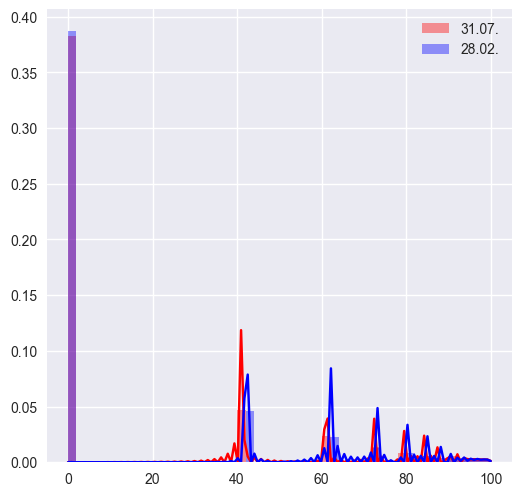

In [23]:
plot_slices(data,"atr1",0,2)